# Week 3

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [4]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

## Estimates for expected returns

In principle, the **Modern Portfolio Theory** (the mean-variance approach of **Markowitz**) offers a solution to this problem once the expected returns and covariances of the assets are known. While Modern Portfolio Theory is an important theoretical advance, **its application has universally encountered a problem**: although the covariances of a few assets can be adequately estimated, **it is difficult to come up with reasonable estimates of expected returns**.

In particular, recall that Markowitz portfolio allocation approach takes in input the set of expected returns and expected volatilities of the assets we are interested in, and gives in output the set of optimal weights in these assets. 

The problem is that **very small changes in the expected returns normally result in large changes in output weights**. Of course, this represent a problem (also because we cannot pretend to invest today in a portoflio by relying on exact past returns and volatilities as they are not likely to be the same in future).

In general, **sample based information** such as the returns computed using sampled past data **are close to useless**. 

Let $N$ be the number of assets in our portfolio.

#### Shrinked expected returns 

A very basic estimate for expected returns is a simple modificiation of sample means. Let 
$$
\mu_i := \frac{1}{T} \sum_{t=1}^{T} r_{t}^{i} 
\quad\text{and}\quad
\bar{\mu} := \frac{1}{N} \sum_{i=1}^N \mu_i, 
$$
be the **sample mean return** of each asset 
and the **grand sample mean** (i.e., the mean of the computed mean returns), respectively. 
The sample mean might be improved by **shrinking** the individual means to the grand sample mean:
$$
\hat{\mu}_i := \delta \bar{\mu} + (1-\delta)\mu_i,
$$
given a shrinking factor $\delta\in [0,1]$ (when $\delta=1$ we are saying that all asset's returns are equal to the grand sample mean).

In [5]:
# these are the \mu_i
asset_means_rets = np.array([11.1, 12.3, 8.4, 15.3, 5.6, 9.7])/100

# this is \bar{\mu} 
grand_sample_mean = asset_means_rets.mean()

# shrinked mean
delta = 0.5
shrinked_mean_ret = delta * grand_sample_mean + (1-delta)* asset_means_rets

print("sample means:   {}%" .format( np.round(asset_means_rets*100,2)) )
print("shrinked means: {}%" .format( np.round(shrinked_mean_ret*100,2) ) )

sample means:   [11.1 12.3  8.4 15.3  5.6  9.7]%
shrinked means: [10.75 11.35  9.4  12.85  8.   10.05]%


### Relying on agnostic priors

Recall that the **expected return and the volatility of a portfolio** of $N$ assets are given by:
$$
\mu_p := \mathbf{w}^T\mathbf{\mu} = \sum_{i=1}^N w_i \mu_i
\quad\text{and}\quad
\sigma_p = (\mathbf{w}^T \Sigma \mathbf{w})^{1/2}, 
$$
where $\mathbf{w}:=(w_1,\dots,w_N)^T$ is the vector of weigths, 
$\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$, where $\mu_i=\mathbb{E}[r_i]$ for each $i=1,\dots,N$ is the expected return of asset $i$, and $\Sigma$ is the expected covariance matrix of the assets.

The vector of expected returns $\mathbf{\mu}:=(\mu_1,\dots,\mu_N)$ is what we are mainly concerned about. 

We have to introduce some, ideally **economically motivated, priors** since using sample based expected returns is not going to work fine.


Let us suppose that we are interested in the maximum sharpe ratio portfolio, i.e., the portoflio or which the sharpe ratio:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} },
$$
is maximum.

#### First agnostic prior: all returns are equal
A very first agnostic prior is assuming that **all expected returns are going to be equal**, for example, equal to the grand sample mean. Of course we know that such assumption would be wrong. However, 
in this case we have:
$$
\mu_i - r_f = \hat{\mu} - r_f \qquad \forall\; i,
$$
hence maximizing the sharpe ratio means, indeed, minimizing the volatility:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i (\hat{\mu} - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \frac{ \hat{\mu} - r_f }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }.
$$

#### Second agnostic prior: sharpe ratios are all equal
A second agnostic prior would be assuming that sharpe ratios are all equal, in particular, this means assuming that the excess 
return $\mu_i-r_f$ of each asset is proportional to the corresponding volatility $\sigma_i$:
$$
\mu_i - r_f = \lambda \sigma_i 
\qquad  \forall\; i, 
$$
where the constant of proportionality $\lambda$ is sharpe ratio supposed to be the same for each asset. In this case, the assumption we are making is simply that **more volatile assets are going to have larger expected returns**. The sharpe ratio of the portfolio becomes:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \frac{ \sum_{i=1}^N w_i \lambda \sigma_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= \lambda \frac{ \sum_{i=1}^N w_i \sigma_i }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }. 
$$
The ratio between the weigthed volatilities and the volatility of the portfolio is known as the **diversification ratio**.

**EXAMPLE:** 
What is the Sharpe ratio of a portfolio of an equally-weighted portfolio of two stocks with volatility equal to $20\%$ and $30\%$, respectively, and a pairwise correlation $0.6$, assuming that they 
both have a Sharpe ratio of $\lambda = 70\%$?

First of all, we have $\sigma_1=0.2$, $\sigma_2=0.3$ and $\rho_{12}=0.6$. The covariance of the stocks is $\text{Cov}(r_1,r_2) = \rho_{12}\sigma_1\sigma_2 = 0.6\cdot 0.2\cdot 0.3 = 0.036$. Then:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p} 
= \lambda \frac{ \sum_{i=1}^2 w_i \sigma_i }{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} } 
= 0.7 \frac{ 0.5\cdot 0.2 + 0.5\cdot 0.3 }{ 
\sqrt{
(0.5, 0.5) 
\begin{pmatrix}
0.04 & 0.036 \\
0.036 & 0.09 
\end{pmatrix}
\begin{pmatrix}
0.5 \\
0.5
\end{pmatrix}
} 
}
=
0.7 \frac{ 0.25 }{ \sqrt{0.0505} } = 77.87\%.
$$

Do we believe that all stocks and all components have the same Sharpe ratio? 
It is a very strong assumption and we have reasons to believe that not all of risk is rewarded. 
In fact, asset pricing theory suggests that **only the systematic component is rewarded** and that 
the specific risk is not rewarded because it can be diversified away. In other words, asset pricing theory suggests that **we should not be rewarded for a piece of risks that we could have diversified away in the first place** and we should instead assume that 
**there is a relationship between excess expected return and (only) the systematic part of volatility**. 

Therefore, we want to **decompose volatility in terms of specific risk and systematic risk**, 
and come up with a better **estimate for expected returns by relating it to systematic risk**. 

We could do this using a **factor model**.

#### Using a factor model to estimate (excess) returns

The simplest factor model that we can use is the **CAPM**. Recall that in the CAPM the expected escess return of an asset was proportional to the excess return of the market:
$$
\mu_i - r_f = \beta_i(\mu_m -r_f)
\qquad \forall \; i,
$$
where $\beta_i$ is the constant of proportionality. This is equivalent to impose that the following ratio:
$$
\text{TR}_i := \frac{\mu_i - r_f}{\beta_i} = \mu_m -r_f,
\qquad \forall \; i
$$
called the **Treynor ratio** is the same for all stocks and equal to the excess return of the market $\mu_m -r_f$. If we accept this model, then the maximum sharpe ratio portfolio would has a sharpe ratio equal to:
$$
\lambda_p = \frac{\mu_p - r_f}{\sigma_p}
= \frac{ \sum_{i=1}^N w_i (\mu_i - r_f)}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }
= (\mu_m - r_f) \frac{ \sum_{i=1}^N w_i \beta_i}{ (\mathbf{w}^T \Sigma \mathbf{w})^{1/2} }, 
$$
where the numerator is the $\beta$ of the portfolio, that is, the weigthed average of $\beta_i$. 

Again, we probably do not want to rely on single-factor models such as the CAMP. 
Below, we consider the $30$ industry portfolios and compare the annualized returns obtained simply using the historical data and using the CAMP model:

In [294]:
# Load data
nind = 30
start = "2013"
ind_rets = erk.get_ind_file(filetype="rets", nind=nind, ew=True)[start:]
fff = erk.get_fff_returns()[start:]
mkt_excess_rets = fff[["Mkt-RF"]]

In [295]:
# compute the excess returns of all industries
rf = pd.DataFrame().reindex_like(ind_rets)
for col in rf.columns:
    rf[col] = fff["RF"].values
ind_exc_rets = ind_rets - rf 
# compute the annualized "historic" mean return
historic_mean = erk.annualize_rets( ind_exc_rets, periods_per_year=12 )
historic_mean.head()

Food     0.114591
Beer     0.203339
Smoke    0.190788
Games    0.138539
Books    0.099739
dtype: float64

In [296]:
# computing beta for each industry  
industries = ind_rets.columns
betas = []
for industry in industries:
    ind_excess_rets = ind_rets[industry] - fff["RF"].values
    lm = erk.linear_regression(ind_excess_rets, mkt_excess_rets)
    betas.append( lm.params[0] )
betas = pd.DataFrame(betas, index=ind_rets.columns, columns=["Mkt-RF"])
# now estimate excess returns of the industries using the CAPM model: beta * exc_ret_of_the_market
capm_rets = []
for industry in betas.index:
    capm_rets.append( erk.annualize_rets( betas.loc[industry] * mkt_excess_rets , periods_per_year=12 )[0] )
capm_rets = pd.Series(capm_rets, index=betas.index)
capm_rets.head()

Food     0.089289
Beer     0.062788
Smoke    0.059317
Games    0.133733
Books    0.147150
dtype: float64

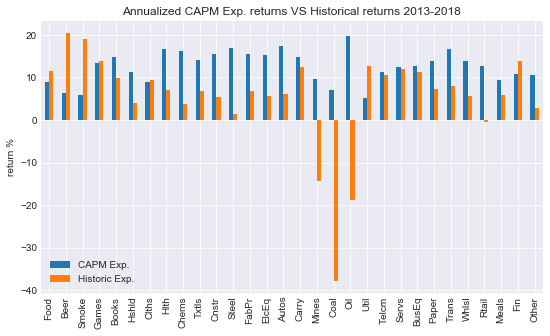

In [297]:
A = pd.concat([capm_rets, historic_mean], axis=1) * 100
A.columns = ["CAPM Exp.","Historic Exp."]
ax = A.plot.bar(grid=True, figsize=(9,5), title="Annualized CAPM Exp. returns VS Historical returns {}-2018".format(start))
ax.set_ylabel("return %")
plt.show()

Observe that the CAPM expected returns are all positives and are contained in a much smaller range of returns. 

## Black-Litterman model

### Background and Theory

The **Black-Litterman model** provides a methodical way of **combining an investors subjective views of the future performance of a risky investment asset with the views implied by the market equilibrium**. 

The procedure can be viewed as a **bayesian shrinkage method that shrinks the expected returns constructed from an investor's views on asset returns towards asset returns implied by the market equilibrium**. 
The procedure firstly computes a set of expected returns (**implied returns**) 
that uses the **market equilibrium implied as a prior**. 
This is then combined with returns implied by subjective investor views to produce a set of posterior expected returns $\mu^{BL}$ and covariances $\Sigma^{BL}$.

Besides the obvious attraction of being able to incorporate subjective investor views, the Black-Litterman procedure has a second feature that makes it extremely attractive to portfolio optimization. 
It is well known that the **Markowitz optimization procedure is highly sensitive to estimation errors in Expected Returns and Covariances**, and this *error maximizing* nature of the Markowitz procedure causes unstable portfolios with extreme weights that diverge rapidly from the market equilibrium portfolio even with minor changes to the inputs. On the other hand, the posterior parameters $\mu^{BL}, \Sigma^{BL}$ computed by the Black-Litterman model are derived in part from the market portfolio, and therefore are much more pragmatic inputs for purposes of portfolio optimization. Specifically, **when $\mu^{BL}, \Sigma^{BL}$ as used as as inputs to a Markowitz Optimizer, they produce optimized weights that diverge from the market portfolio in limited ways**, and only to the extent of the confidence that the investor expresses in the views. Consequently **the optimized portfolios are more stable portfolios than with pure Markowitz optimization with sample estimates**. 


### Benchmark 

The first step in the Black-Litterman model is the extraction of **implied expected return estimates**. Recall that when we want to construct an optimal portfolio we have to give in inputs some expected return estimates as well as some risk parameters estimates (volatilities). 

While risk parameter estimates are *easy* to find, it is much more difficult to come up with meaningful 
return estimates. This is why we end up with concluding that the **value added of the skill of active portfolio management** plays a major role. 
We will refer to them as **active views about the expected returns**, i.e., what managers' opionions about expected returns are.

Assume that we have at our disposal a set of active views about expected returns. 
**How can we incorporate those active views in the portfolio construction process?**

The first challenge is to find **a meaningful anchor point, a meaningful benchmark**, to which a portfolio that we are holding can converge to in case, for example, the acting manager loses confidence in its views or imply does not even have views on any particular circumstances.

**The Black-Litterman model suggests to use the market portfolio, the CAPM**.

### Reverse engineering: extract implied returns

The Black-Litterman model is based on an assumption that expected returns have greatest impact to portfolio weightings in mean-variance optimization. Therefore, **the model attempts to extract such return in a reverse-engineer way from the benchmark constituents** rather than relying on historical data.

Think about the engineering of portfolio construction for a set of $N$ assets. 
We have a set of expected return $\{\mu_i\}$, for $i=1,\dots,N$, and a covariance matrix $\Sigma$. Then we use portfolio optimization with 
these inputs and obtain as output the set of optimal portfolio weights $\{w^*_i\}$:
$$
\left\{ \mu_i, \Sigma:=[c_{ij}]\right\}_{i,j=1,\dots,N} 
\quad\longrightarrow\quad 
\{w^*_i\}_{i=1,\dots,N}.
$$
In a **reverse-reverse engineering** process we do not take in input the expected returns (we do not have meaningful return estimates). We will still take the covariance matrix $\Sigma$ and then we take the **benchmark weights** $\{w_i^{\text{benchmark}} \}$. 
For example, if our benchmark is cap-weighted (resp. equally-weigthed), we will take cap-weighted (resp. equally-weigthed) weights. Then, we will extract the value for expected returns corresponding to such weigths:
$$
\left\{ w_i^{\text{benchmark}}, \Sigma:=[c_{ij}]\right\}_{i,j=1,\dots,N} 
\quad\longrightarrow\quad
\Pi := \{\mu_i^{\text{implied}}\}_{i=1,\dots,N}.
$$
We call the extracted returns the **implied returns**. 

In equilibrium, all investors as a whole hold the market portfolio $\mathbf{w}^{\text{benchmark}} := \{ w_i^{\text{benchmark}} \}$. 
The equilibrium risk premiums $\Pi$ (the implied returns) are such that if all investors hold the same view, 
the demand for these assets exactly equals to the outstanding supply. 
Assuming that the average risk tolerance of the world is represented by the **risk aversion parameter $\delta$**, 
the implied returns are then given by:
$$
\Pi = \delta \Sigma \mathbf{w}^{\text{benchmark}}.
$$

In principle, the risk aversion parameter $\delta$ can be set arbitrarily. For instance, some authors use $\delta = 2.5$ while 
others use $\delta = 2.14$ of $\delta=2.65$. Another common approach is to set $\delta$ to the Market Price of Risk 
(i.e., a measure of the risk aversion of the Representative Investor, which is computed as $\delta = \mu_M/\sigma^2_M$ 
where $\mu_M$ and $\sigma^2_M$ are estimates of the mean and variance of the returns of the market portfolio). 
Frequently, a broad market index such as the **S\&P500** is taken as a proxy for the market in order to compute 
the market price of risk from $\mu_M$ and $\sigma^2_M$.

We are going to treat this vector of implied returns as an anchor point and we also add some kind of uncertainty around it. 
That is, the Bayesian prior is that the expected returns $\mu$ are centered at the equilibrium values, that is 
they are normally distributed with the mean of $\Pi$:
$$
\mu = \Pi + \varepsilon^{(e)},
$$
where $\varepsilon^{e} \sim \mathcal{N}(0,\tau\Sigma)$ is a normally distributed random vector with zero mean and 
covariance matrix $\tau\Sigma$, where $\tau$ is a scalar indicating the uncertainty of the CAPM prior.

The treatment of $\tau$ is the source of some confusion. 
Some implementors have done away with $\tau$ by setting it to $1$. 
However, in the original model, Black and Litterman suggest using a small number: a common technique is to set $\tau = 1/T$ where $T$ is the number of periods of data used. For example, for $5$ years of monthly data ($T=5\cdot 12=60$) data, then $\tau=1/60=0.016$. 

### Active views

In addition to the Bayesian CAPM prior, the investors also have a number of **active views** on the market returns. A **view** is expressed as a statement that the expected return of a portfolio has a normal distribution with a certain mean equal to 
$q$ and a standard deviation given by $\omega$. 

Let $K$ bet the number of views. Let $P$ be a $K\times N$ matrix (**Projection matrix**) that identifies the assets involved in the views
and $Q$ be a $K\times 1$ vector of the expected returns on these portfolios (**Views vector**):
$$
P = 
\begin{pmatrix}
p_{11} & p_{12} & \dots  & p_{1N} \\
\vdots & \vdots & \ddots & \vdots \\
p_{K1} & p_{K2} & \dots  & p_{KN} \\
\end{pmatrix}
\qquad
Q = 
\begin{pmatrix}
q_{1}  \\
\vdots  \\
q_{K}.
\end{pmatrix}
$$
The entries $\{p_{kn}\}$ are the weights of the corresponding $K$ portfolio composed of $N$ assets (asset weigths within each view).

The investor's views can be expressed as:
$$
P\mu = Q + \varepsilon^{(\nu)},
$$
where $\varepsilon^{(\nu)} \sim \mathcal{N}(0,\Omega)$ is an unobservable normally distributed random vector 
with zero mean and a diagonal $K\times K$ covariance matrix $\Omega$. 
It is further assumed that the $\varepsilon^{(e)}$ and $\varepsilon^{(\nu)}$ are independent:
$$
\begin{pmatrix}
\varepsilon^{(e)}  \\
\varepsilon^{(\nu)}
\end{pmatrix} 
\sim 
\mathcal{N}
\left(
0,
\begin{pmatrix}
\tau\Sigma & 0  \\
0          & \Omega \\
\end{pmatrix}
\right).
$$

Views are represented in $Q$ and $P$ as follows: 
- if the $k$-th view is an **absolute view of asset $i$**, then it is represented by setting $q_k$ to the expected return of asset $k$ and setting $p_{ki} = 1$ and all other elements of row $k$ in $P$ to zero.
- If the $k$-th view is **a relative view between assets $i$ and $j$**, then it is represented by setting $q_k$ to the expected difference of returns between assets $i$ and $j$ and setting $p_{ki} = -1$ for the underperforming asset, $p_{kj} = +1$ 
and all other elements of row $k$ in $P$ to zero. 

**EXAMPLE**: consider the following investor views. We have $N=4$ assets and $K=2$ views. 
The investor has a first **relative view** in which he believes that asset 1 will outperform asset 3 by $2\%$ with confidence $\omega_1=\omega_{11}$. 
Then he has a second **absolute view** in which he believes that asset 2 will return $3\%$ with confidence $\omega_2=\omega_{22}$. 
The investor has no view on asset 4, and thus its return should not be directly adjusted. These views are specified as follows:
$$
P = 
\begin{pmatrix}
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 0 
\end{pmatrix},
\qquad
Q = 
\begin{pmatrix}
0.02 \\
0.03 
\end{pmatrix},
\qquad
\Omega = 
\begin{pmatrix}
\omega_{11} & 0 \\
0 & \omega_{22}
\end{pmatrix}
$$
Therefore, we would have:
$$
\begin{pmatrix}
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 0 
\end{pmatrix}
\begin{pmatrix}
\mu_1 \\
\mu_2 \\
\mu_3 \\
\mu_4 \\
\end{pmatrix}
= 
\begin{pmatrix}
\mu_1 - \mu_3 \\
\mu_2 \\
\end{pmatrix}
= 
\begin{pmatrix}
0.02 \\
0.03 \\
\end{pmatrix}
+ 
\begin{pmatrix}
\varepsilon^{(\nu)}_1 \\
\varepsilon^{(\nu)}_2
\end{pmatrix}
\qquad\Longrightarrow\qquad
\begin{cases}
\mu_1 - \mu_3 &= 0.02 + \varepsilon^{(\nu)}_1 \\
\mu_2 &= 0.03 + \varepsilon^{(\nu)}_2 \\
\end{cases}
$$


The uncertainty of the views $\Omega$ is either set by the user, or inferred (e.g., via statements of confidence, 
from market data, from the variance of residuals from a prediction model used to generate the views, etc.). 

The following paper:
- [HE99] **He, Litterman, The intuition behind the Black-Litterman model portfolios, 1999**

suggests that if the investor does not explicitly quantify the uncertainty associated with the views 
in the matrix $\Omega$, we could make the assumption that $\Omega$ is proportional to the variance of the prior, specifically,
$$
\Omega = \text{diag}\left(P (\tau \Sigma) P^T \right).
$$

### Mixing implied returns with active views

The views are then combined with the CAPM prior in the Bayesian framework.
The result is that the expected returns are distributed as $\mathcal{N}(\mu^{BL},M^{-1})$, 
where $\mu^{BL}$ (**posterior vector**) is given by:

\begin{equation}
\label{eq:bl:mu}
\mu^{BL} = 
\bigl( \underbrace{ (\tau\Sigma)^{-1} + P^T \Omega^{-1} P }_{N\times N}   \bigr)^{-1} 
\bigl( \underbrace{ (\tau\Sigma)^{-1} \Pi + P^T \Omega^{-1} Q }_{N\times 1}   \bigr),
\end{equation}

and $M^{-1}$ given by:

\begin{equation}
\label{eq:bl:sigma}
M^{-1} = 
\bigl( \underbrace{ (\tau\Sigma)^{-1} + P^T \Omega^{-1} P }_{N\times N}   \bigr)^{-1}.
\end{equation}

Here **$M$, i.e. the posterior variance**, is actually the variance of the posterior mean estimate about the actual mean. 
That is, it is the uncertainty in the posterior mean estimate, and **is not the variance of the returns**. 
Computing the posterior covariance of returns requires adding the variance of the estimate about the mean 
to the variance of the distribution about the estimate, i.e., 
$$
\Sigma^{BL} = \Sigma + M^{-1} = \Sigma + \bigl( (\tau\Sigma)^{-1} + P^T \Omega^{-1} P  \bigr)^{-1}.
$$

The set of equations above is known as the **Black-Litterman Master Formula**. 
It is important to recognize that even when the manager has very little or zero confidence in their views, 
then the process will eventually make it sure that the portfolio we are holding holding converges smoothly towards the 
benchmark portfolio.

While the master formulas identified are frequently easy to implement, they do involve the term $\Omega^{-1}$ and 
**$\Omega$ is sometimes non-invertible**. Fortunately, the equations are easily transformed to a form that does not require 
inverting $\Omega$:

\begin{equation}
\mu^{BL} = \Pi + \tau \Sigma P^T \bigl( P \tau \Sigma P^T + \Omega\bigr)^{-1} \bigl(Q - P \Pi\bigr),
\end{equation}

\begin{equation}
\Sigma^{BL} = \Sigma + \tau \Sigma - \tau\Sigma P^T\bigl(P \tau \Sigma P^T + \Omega\bigr)^{-1} P \tau \Sigma.
\end{equation}

### Implementation Overview

First of all, we compare naive markowitz optimization with portfolio allocation using the Black-Litterman model with both absolute view and relative views.

#### A first example: absolute views

We start with a simple 2-Asset example. We choose an example from the book 
**T. Lai and H. Xing, Statistical Models and Methods for Financial Markets, 2008th Ed**. 

Consider the portfolio consisting of just two stocks: **Intel (INTC) and Pfizer (PFE)**. 
From Table 3.1 on page 72 of the book, we obtain the covariance matrix (multipled by $10^{-4}$):

\begin{array}{lcc}
\text{INTC} & 46.0 & 1.06 \\
\text{PFE}   & 1.06 & 5.33
\end{array}

Assume that Intel has a market capitalization of approximately **USD 80B** and that of Pfizer is approximately **USD 100B** 
(this is not quite accurate, but works just fine as an example). Thus, if we held a market-cap weighted portfolio, we 
would hold INTC and PFE with the following weights: $w_{\text{INTC}} = 80/180 = 44\%$ and $w_{\text{PFE}} = 100/180 = 56\%$. 
These appear to be reasonable weights without an extreme allocation to either stock, even though Pfizer is slightly overweighted.

Recall that the first step in the **Black-Litterman** procedure was to reverse engineer the implied returns vector 
$\Pi$ from a set of portfolio weights $\mathbf{w}$. Here, the portfolio weights $\mathbf{w}$ are the benchmark weights 
(CAPM cap-weigthed weigths):
$$
\Pi = \delta\Sigma \mathbf{w}^{\text{benchmark}}.
$$

We can compute the **equilibrium implied returns** $\Pi$ as follows:

In [5]:
tickers = ['INTC', 'PFE']
Sigma = pd.DataFrame([[46.0, 1.06], [1.06, 5.33]], index=tickers, columns=tickers) * 10E-4
weigths = pd.Series([0.44, 0.56], index=tickers)

Pi = erk.implied_returns(Sigma, weigths, delta=2.5)
Pi

INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Thus the equilibrium implied returns for **INTC** are a bit more than $5\%$ and a bit less than $1\%$ for PFE.

Now, assume that the investor has $2$ absolute views: he thinks that Intel will return $2\%$ and that Pfizer will return $4\%$. 
We can now examine the optimal weights according to the Markowitz procedure. 
What would happen if we **used these expected returns to compute the maximum Sharpe Ratio portfolio?**

Note that the maximum Sharpe Ratio portfolio weights are easily computed in explicit form if there are no constraints on the weights.
The weights are given by the expression:
$$ 
w_{\text{MSR}} = \frac{\Sigma^{-1}\mu_e}{{\bf{1}}^T \Sigma^{-1}\mu_e}, 
$$
where $\mu_e := (\mathbf{R}-R_f\mathbf{1})$ is the vector of expected excess returns (**see the notebook of week 2 of Course 1**) 
and $\Sigma$ is the variance-covariance matrix.

We can examine the optimal weights obtained by naively implementing the Markowitz procedure with these expected returns.

In [76]:
# INTC and PFE
mu_exp = pd.Series([0.02, 0.04], index=tickers)
np.round( erk.weigths_max_sharpe_ratio(Sigma, mu_exp)*100, 2)

INTC     3.41
PFE     96.59
dtype: float64

In [77]:
# which is equivalent to run:
#max_shp_w = erk.maximize_shape_ratio(mu_exp, Sigma, risk_free_rate=0, periods_per_year=1)
#max_shp_w = pd.Series(max_shp_w, index=tickers) 
#round( max_shp_w * 100, 2 )

Consistent with the poor reputation of naive Markowitz optimization, the Markwitz procedure places an unrealistic weight of more than $96\%$ 
in Pfizer and less than $4\%$ in Intel. This is completely impractical and no reasonable investor would make such dramatic bets.

In contrast, let us now find the weights that the Black-Litterman model would place. 
We allow $\Omega$ to be computed automatically. We find the Black Litterman weights as follows:

In [78]:
# Weights prior
w_prior = pd.Series([0.44, 0.56], index=tickers)

# Absolute view 1: INTC will return 2%
# Absolute view 2: PFE will return 4%
Q = pd.Series([0.02, 0.04], index=tickers)

# Projection Matrix
P = pd.DataFrame( np.array([[1,0],[0,1]]), columns=tickers )

# Black-Litterman Expected Returns
bl_mu, bl_sigma = erk.black_litterman(w_prior, Sigma, P, Q)

In [79]:
bl_mu

INTC    0.037622
PFE     0.024111
dtype: float64

The posterior returns returned by the procedure are clearly weighted between that of the equilibrium implied expected returns 
(in the range of about $(1\%, 5\%)$) and that of the investor (in the range $(2\%,4\%)$). 
The question is **are these weights likely to yield more realistic portfolios?** 
To answer that question we supply the Black-Litterman expected returns and covariance matrix to the optimizer:

In [80]:
# Use the Black-Litterman expected returns to get the optimal Markowitz weights
max_shp_w = erk.maximize_shape_ratio(bl_mu, bl_sigma, risk_free_rate=0, periods_per_year=1)
max_shp_w = pd.Series(max_shp_w, index=tickers)
round( max_shp_w * 100, 2 )

INTC    14.02
PFE     85.98
dtype: float64

We see that we get much more reasonable weights than we did with naive optimization. 
These weights are also much closer to the 45-55 mix in the cap weighted portfolio.
On the other hand, they respect the investor's view that expects Pfizer to rebound, and places a higher weight on Pfizer relative to the cap weighted portfolio.

#### A second example: relative views

In this example, we examine relative views. 
We stick with our simple 2-stock example. Recall that the Cap-Weighted implied expected returns are:

In [7]:
Pi

INTC    0.052084
PFE     0.008628
Name: Implied Returns, dtype: float64

Assume that **the investor feels that Intel will outperform Pfizer by $2\%$**. This view is implemented as follows:

In [8]:
# Weights prior
w_prior = pd.Series([0.44, 0.56], index=tickers)

# Relative views
Q = pd.Series([0.02])

# Projection matrix
P = pd.DataFrame([[+1, -1]], columns=tickers)

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = erk.black_litterman(w_prior, Sigma, P, Q)

In [9]:
bl_mu

INTC    0.041374
PFE     0.009646
dtype: float64

Once again we see that the Black-Litterman expected returns are a blend between the cap-weight implied weights and the investor view. 

**The outperformance of Intel in the implied returns is**:

In [10]:
round( (Pi["INTC"] - Pi["PFE"])*100, 2)

4.35

**In contrast, the investor felt it only would be $2\%$**. The expected returns returned by the 
Black-Litterman procedure show a spread that is a blend between the cap-weight implied returns and that of the investor:

In [11]:
round( (bl_mu["INTC"] - bl_mu["PFE"] )*100, 2)

3.17

And, the weights in the optimized portfolio when we use these expected returns are:

In [12]:
# Use the Black-Litterman expected returns to get the optimal Markowitz weights
max_shp_w = erk.maximize_shape_ratio(bl_mu, bl_sigma, risk_free_rate=0, periods_per_year=1)
max_shp_w = pd.Series(max_shp_w, index=tickers)
round( max_shp_w * 100, 2 )

INTC    34.8
PFE     65.2
dtype: float64

These seem reasonable weights, and demonstrates the power of using the Black-Litterman procedure. 

In contrast, consider the weights that we would get if we implemented the same view without Black-Litterman. 
We set the returns of Intel and Pfizer to be $3\%$ and $1\%$, respectively, and we use the variance-covariance matrix $\Sigma$:

In [98]:
rets = pd.Series([0.03, 0.01], index=tickers)
max_shp_w = erk.maximize_shape_ratio(rets, Sigma, risk_free_rate=0, periods_per_year=1)
max_shp_w = pd.Series(max_shp_w, index=tickers)
round( max_shp_w * 100, 2 )

INTC    25.87
PFE     74.13
dtype: float64

The weights are significantly more dramatic than one might be willing to implement, and are likely unwarranted given the relatively weak view. In fact, **if the same view were implemented as Intel and Pfizer returning $2\%$ and $0\%$**, the results are even more extreme:

In [13]:
# using the maximize_shape_ratio we have the weigths that sum to 1
rets = pd.Series([0.02, 0.0], index=tickers)
max_shp_w = erk.maximize_shape_ratio(rets, Sigma, risk_free_rate=0, periods_per_year=1)
max_shp_w = pd.Series(max_shp_w, index=tickers)
round( max_shp_w * 100, 2 )

INTC    100.0
PFE       0.0
dtype: float64

In [14]:
# whereas using explictic formulas through weigths_max_sharpe_ratio we obtain negative weigths
np.round( erk.weigths_max_sharpe_ratio(Sigma, rets)*100, 2)

INTC    124.82
PFE     -24.82
dtype: float64

In this case, the Markowitz recommends shorting Pfizer to the extent of nearly $25\%$ of the portfolio and 
leveraging Intel to $125\%$. Clearly this is not a plausible allocation based on the simple view expressed above.

### Reproducing the He-Litterman (1999) Results

We now reproduce the results in the He-Litterman paper that first detailed the steps in the procedure. 
We obtained the data by typing it in from the He-Litterman tables, and used it to test the implementation.

The He-Litterman example involves **an international allocation between 7 countries**. The data is as follows:

In [15]:
# The 7 countries:
countries  = ['AU', 'CA', 'FR', 'DE', 'JP', 'UK', 'US'] 

# Table 1 of the He-Litterman paper
# Correlation Matrix
rho = pd.DataFrame([
    [1.000,0.488,0.478,0.515,0.439,0.512,0.491],
    [0.488,1.000,0.664,0.655,0.310,0.608,0.779],
    [0.478,0.664,1.000,0.861,0.355,0.783,0.668],
    [0.515,0.655,0.861,1.000,0.354,0.777,0.653],
    [0.439,0.310,0.355,0.354,1.000,0.405,0.306],
    [0.512,0.608,0.783,0.777,0.405,1.000,0.652],
    [0.491,0.779,0.668,0.653,0.306,0.652,1.000]
], index=countries, columns=countries)

# Table 2 of the He-Litterman paper: volatilities
vols = pd.DataFrame([0.160,0.203,0.248,0.271,0.210,0.200,0.187], index=countries, columns=["vol"]) 

# Table 2 of the He-Litterman paper: cap-weights
w_eq = pd.DataFrame([0.016,0.022,0.052,0.055,0.116,0.124,0.615], index=countries, columns=["CapWeight"])

# Compute the variance-covariance matrix
sigma_prior = rho * vols.dot(vols.T)

# Compute implied returns Pi:
Pi = erk.implied_returns(covmat=sigma_prior, weigths=w_eq, delta=2.5)

(Pi*100).round(1)

AU    3.9
CA    6.9
FR    8.4
DE    9.0
JP    4.3
UK    6.8
US    7.6
Name: Implied Returns, dtype: float64

The values of $\Pi$ computed by the Python code exactly matches column 3 of Table 2.

In [18]:
erk.weigths_max_sharpe_ratio(sigma_prior, Pi)

AU    0.016
CA    0.022
FR    0.052
DE    0.055
JP    0.116
UK    0.124
US    0.615
dtype: float64

### View 1: Germany vs Rest of Europe

We impose the view that German equities will outperform the rest of European equities by $5\%$. 
The other European equities are, in this cases, France and the UK. 
We split the outperformance proportional to the Market Caps of France and the UK.

In [19]:
# Germany will outperform other European Equities (i.e. FR and UK) by 5%. Relative views
Q = pd.Series([0.05])

# start with a single view, all zeros and overwrite the specific view
P = pd.DataFrame([0.]*len(countries), index=countries).T

# find the relative market caps of FR and UK to split the relative outperformance of DE, i.e., 
# capweigth of France with respect to "Rest of Europe", i.e. France and UK
w_fr =  w_eq.loc["FR"] / (w_eq.loc["FR"] + w_eq.loc["UK"])
# capweigth of UK with respect to "Rest of Europe", i.e. France and UK
w_uk =  w_eq.loc["UK"] / (w_eq.loc["FR"] + w_eq.loc["UK"])

# assign weigths
P.iloc[0]['DE'] = 1.
P.iloc[0]['FR'] = -w_fr
P.iloc[0]['UK'] = -w_uk

(P*100).round(1)

,AU,CA,FR,DE,JP,UK,US
0,0.0,0.0,-29.5,100.0,0.0,-70.5,0.0


The results of implementing this view appear in the He-Litterman paper in Table 4. 
This exactly reproduces column 1 of Table 4. Next, we examine the values of $\mu^{BL}$:

In [20]:
delta = 2.5
tau   = 0.05 # from Footnote 8

# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = erk.black_litterman(w_eq, sigma_prior, P, Q, tau=tau)
(bl_mu*100).round(1)

AU     4.3
CA     7.6
FR     9.3
DE    11.0
JP     4.5
UK     7.0
US     8.1
dtype: float64

The Black-Litterman expected returns computed by the code exactly reproduces column 2 of Table 4.

He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper):

In [21]:
def w_star(sigma, mu, delta=2.5):
    return ( erk.inverse_df(sigma).dot(mu) ) / delta

wstar = w_star(sigma=bl_sigma, mu=bl_mu, delta=2.5)
(wstar*100).round(1)

AU     1.5
CA     2.1
FR    -4.0
DE    35.4
JP    11.0
UK    -9.5
US    58.6
dtype: float64

The computed $w^*$ exactly replicates column 3 of Table 4. Finally, they compute $w^* - \frac{w_{eq}}{1+\tau}$ which is the difference in weights between the optimal portfolio and the equilibrium portfolio (they use unscaled weights) in column 4. 
We replicate that column as follows:

In [22]:
w_eq = erk.weigths_max_sharpe_ratio(delta*sigma_prior, Pi, scale=False)

# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU     0.0
CA    -0.0
FR    -8.9
DE    30.2
JP     0.0
UK   -21.3
US     0.0
dtype: float64

which exactly matches Column 4 of Table 4. This completes our reproduction of the first view in He-Litterman (1999).

Note that this demonstrates the power of the approach. The weights for assets that do not involve the view remain unchanged. The two underperforming countries (according to the view) are underweighted, while the overperforming country is overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.

### View 2: Canada vs US

For their second case, He and Litterman implemented the additional view that Canadian Equities will outperform US Equities by $3\%$. 
The results are in (their) Table 5.

In [23]:
Q = Q.append( pd.Series([0.03], index=[1]) )

P = P.append( pd.DataFrame([0.]*len(countries), index=countries, columns=[1]).T )
P.iloc[1]['CA']= +1.0
P.iloc[1]['US']= -1.0

In [24]:
np.round(P, 3)*100

,AU,CA,FR,DE,JP,UK,US
0,0.0,0.0,-29.5,100.0,0.0,-70.5,0.0
1,0.0,100.0,0.0,0.0,0.0,0.0,-100.0


This matches columns 1 and 2 of Table 5. We now compute the Black Litterman weights as
before:

In [25]:
bl_mu, bl_sigma = erk.black_litterman(w_eq, sigma_prior, P, Q, tau=tau)
np.round(bl_mu*100, 1)

AU     4.4
CA     8.7
FR     9.5
DE    11.2
JP     4.6
UK     7.0
US     7.5
dtype: float64

The Black Litterman expected returns computed by the Python code exactly reproduces column 3 of Table 5.
He-Litterman compute the optimal portfolio weigths $w^*$ as follows (this is Equation (13) on page 6 of their paper):

In [26]:
wstar = w_star(sigma=bl_sigma, mu=bl_mu, delta=2.5)
(wstar*100).round(1)

AU     1.5
CA    41.9
FR    -3.4
DE    33.6
JP    11.0
UK    -8.2
US    18.8
dtype: float64

The computed $w^*$ exactly replicates column 4 of Table 5. Finally, as in the previous case, 
they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 5. We replicate that column as follows:

In [28]:
# difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU    -0.0
CA    39.8
FR    -8.4
DE    28.4
JP     0.0
UK   -20.0
US   -39.8
dtype: float64

Which exactly reproduces the last column of Table 5 of their paper.

Once again, we see the power of the approach. The weights for assets that do not involve the view (AU, JP) remain unchanged. The two underperforming countries (FR, UK, US, according to the view) are underweighted, while the overperforming countries (CA, DE) are overweighted, but not to the extreme extent that a naive portfolio optimizer would have produced.

### View 3: More Bullish Canada vs US

For their third case, He and Litterman alter the second view that Canadian Equities will outperform US Equities by increasing the 
expected out-performance from the previously stated $3\%$ to $4\%$. 
The results are in Table 6 of their paper.

In [29]:
# update the views
Q[1] = 0.04
Q

0    0.05
1    0.04
dtype: float64

Note that P remains unchanged since we have only altered Q, not P. We now compute the Black Litterman weights as before:

In [30]:
bl_mu, bl_sigma = erk.black_litterman(w_eq, sigma_prior, P, Q, tau=tau)
np.round(bl_mu, 3)*100

AU     4.4
CA     9.1
FR     9.5
DE    11.3
JP     4.6
UK     7.0
US     7.3
dtype: float64

The  Black-Litterman expected returns reproduces column 3 of Table 6. 
He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper):

In [31]:
wstar = w_star(sigma=bl_sigma, mu=bl_mu, delta=2.5)
(wstar*100).round(1)

AU     1.5
CA    53.3
FR    -3.3
DE    33.1
JP    11.0
UK    -7.8
US     7.3
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. 
Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:

In [32]:
w_eq = erk.weigths_max_sharpe_ratio(delta*sigma_prior, Pi, scale=False)

# difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU    -0.0
CA    51.3
FR    -8.2
DE    27.8
JP    -0.0
UK   -19.6
US   -51.3
dtype: float64

Which exactly reproduces the last column of Table 6 of their paper. 
Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

### View 4: increasing view uncertainty

As a final step, He and Litterman demonstrate the effect of $\Omega$. They increase the uncertainty associated with the first of the two views (i.e. the one that Germany will outperform the rest of Europe). First we compute the default value of $\Omega$ and then increase the uncertainty associated with the first view alone.

In [33]:
# compute the default Omega
omega = erk.omega_uncertain_prior(sigma_prior, tau, P)

# Now, double the uncertainty associated with View 1
omega.iloc[0,0] = 2*omega.iloc[0,0]
omega

,0,1
0,0.00213,0.000000
1,0.00000,0.000852


We now compute the Black Litterman weights as before, but supplying the value of $\Omega$ we just adjusted:

In [34]:
bl_mu, bl_sigma = erk.black_litterman(w_eq, sigma_prior, P, Q, tau=tau, Omega=omega)
np.round(bl_mu, 3)*100

AU     4.3
CA     8.9
FR     9.3
DE    10.6
JP     4.6
UK     6.9
US     7.2
dtype: float64

The  Black-Litterman expected returns computed by the code exactly reproduces column 3 of Table 7. 
He-Litterman compute the optimal portfolio $w^*$ as follows (this is Equation (13) on page 6 of their paper)

In [35]:
wstar = w_star(sigma=bl_sigma, mu=bl_mu, delta=2.5, )
(wstar*100).round(1)

AU     1.5
CA    53.9
FR    -0.5
DE    23.6
JP    11.0
UK    -1.1
US     6.8
dtype: float64

The computed $w^*$ exactly replicates column 4 ($w^*$) of Table 7. 
Finally, as in the previous case, they compute $w^* - \frac{w_{eq}}{1+\tau}$ in column 6. We replicate that column as follows:

In [37]:
# difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

AU    -0.0
CA    51.8
FR    -5.4
DE    18.4
JP     0.0
UK   -13.0
US   -51.8
dtype: float64

Which exactly reproduces the last column of Table 7 of their paper. 
Again, we see how the weights increase allocations consistent with the view, but keep allocations from getting extreme.

That concludes our reproduction of the paper. Note that He and Litterman also produce an extra table (Table 8) which demonstrates the value of adding a third view. However, the third view is identical to the values implied by the equilibrium and as a result, they produce exactly the same results as Table 7. I do not bother reproduce it here since the results are exactly the same as Table 7.